In [1]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout, Embedding, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, precision_score, recall_score, hamming_loss, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold

import numpy as np
import pandas as pd

# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


## Import filtered data

In [2]:
discharge_df = pd.read_pickle('sample_input')
discharge_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICD9_CODE
0,1,23224,174680.0,2147-12-05,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2147-11-17**] ...,[4280]
1,2,23224,117806.0,2154-05-03,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2154-4-30**] ...,"[0389, 486, 99592, 311]"
2,3,19051,184534.0,2172-04-23,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2172-3-26**] ...,"[5070, 99592, 4019]"
3,4,14605,195146.0,2198-11-27,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2198-11-23**] ...,"[5849, 2762, 2859, 4019]"
4,5,9446,154895.0,2190-05-22,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2190-5-16**] Discharge...,"[41401, 4019, 25000]"


## Extract/preprocess data

In [3]:
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 100

#### Tokenize free text

In [4]:
X = discharge_df.TEXT.values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 241153 unique tokens.


#### Transform the 25 text labels into a binary list 

In [7]:
y = discharge_df['ICD9_CODE'].values

possible_classes = set([item for sublist in y for item in sublist])
lb = MultiLabelBinarizer(classes=list(possible_classes))
labels = lb.fit_transform(y)

In [8]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', np.array(labels).shape)

('Shape of data tensor:', (58410, 1000))
('Shape of label tensor:', (58410, 25))


#### Split data into 80% training, 10% validation, 10% test data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    data,labels,test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test,test_size=0.5)

#### Prepare embedding layer: parse pre-trained embeddings

In [19]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors.'.format(len(embeddings_index)))

Found 400000 word vectors.


In [20]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [21]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

## LSTM model

In [22]:
nb_epoch = 10
batch_size=128

stop_monitor = 'val_loss'
patience = 5 # number of epochs with no improvement to early stop

In [23]:
model = Sequential()
model.add(Embedding(len(word_index)+1, EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH, 
                    trainable=False))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.005), metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         24115400  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 64)          34048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 64)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                10368     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                825       
Total params: 24,160,641
Trainable params: 45,241
Non-trainable params: 24,115,400
___________________________________________________________

In [25]:
early_stop = EarlyStopping(monitor=stop_monitor, 
                           patience=patience, mode='auto')
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    batch_size=batch_size, nb_epoch=nb_epoch, 
                    callbacks=[early_stop], class_weight='auto')

/Users/andreacastro/miniconda2/lib/python2.7/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 46728 samples, validate on 5841 samples
Epoch 1/10
46728/46728 [==============================] - 757s 16ms/step - loss: 0.3687 - acc: 0.8675 - val_loss: 0.3445 - val_acc: 0.8738
Epoch 2/10
46728/46728 [==============================] - 780s 17ms/step - loss: 0.3427 - acc: 0.8731 - val_loss: 0.3239 - val_acc: 0.8766
Epoch 3/10
46728/46728 [==============================] - 743s 16ms/step - loss: 0.3231 - acc: 0.8776 - val_loss: 0.3053 - val_acc: 0.8827
Epoch 4/10
46728/46728 [==============================] - 728s 16ms/step - loss: 0.3137 - acc: 0.8809 - val_loss: 0.3042 - val_acc: 0.8812
Epoch 5/10
46728/46728 [==============================] - 744s 16ms/step - loss: 0.3089 - acc: 0.8826 - val_loss: 0.3017 - val_acc: 0.8820
Epoch 6/10
46728/46728 [==============================] - 1975s 42ms/step - loss: 0.3048 - acc: 0.8843 - val_loss: 0.2976 - val_acc: 0.8845
Epoch 7/10
46728/46728 [==============================] - 864s 18ms/step - loss: 0.3008 - acc: 0.8854 - val_loss: 0.

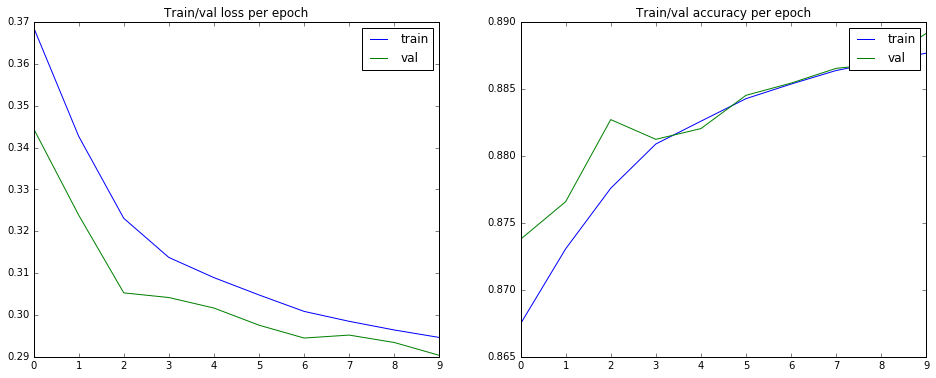

In [28]:
# plot progress
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=True, figsize=(16, 6))
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='val')
ax1.set_title('Train/val loss per epoch')
ax1.legend()

ax2.plot(history.history['acc'], label='train')
ax2.plot(history.history['val_acc'], label='val')
ax2.set_title('Train/val accuracy per epoch')
ax2.legend()
plt.show()

In [ ]:
preds = model.predict(X_test)
preds[preds>=0.5]=1
preds[preds<0.5]=0

micro_p = precision_score(y_test,preds, average='micro')
macro_p = precision_score(y_test,preds,average='macro')
micro_r = recall_score(y_test,preds,average='micro')
macro_r = recall_score(y_test,preds,average='macro')
macro_f1 = f1_score(y_test,preds,average='macro')
micro_f1 = f1_score(y_test,preds,average='micro')
micro_roc = roc_auc_score(y_test,preds,average='micro')
macro_roc = roc_auc_score(y_test,preds,average='macro')
hamming = hamming_loss(y_test,preds)

results = [micro_p,macro_p,micro_r, macro_r, micro_f1, macro_f1, micro_roc, macro_roc, hamming]
results_df = results_df.append(pd.Series(results, index=results_df.columns), ignore_index=True)
results_df.head()

## Demo

In [38]:
discharge_df.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICD9_CODE
0,1,23224,174680.0,2147-12-05,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2147-11-17**] ...,[4280]
1,2,23224,117806.0,2154-05-03,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2154-4-30**] ...,"[0389, 486, 99592, 311]"
2,3,19051,184534.0,2172-04-23,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2172-3-26**] ...,"[5070, 99592, 4019]"
3,4,14605,195146.0,2198-11-27,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2198-11-23**] ...,"[5849, 2762, 2859, 4019]"
4,5,9446,154895.0,2190-05-22,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2190-5-16**] Discharge...,"[41401, 4019, 25000]"


#### Preprocessing

In [39]:
X = X_test[:5]
X[0]

array([   352,   1337,     11,    569,   2973,   3596,   5186,     31,
          145,   1517,    174,     65,   1798,   3139,    368,    180,
          285,      5,   3588,      3,     52,   7839,   1597,     10,
          611,   4533,    885,    206,   5700,      2,     14,   2811,
          764,    750,     14,   5723,  11720,      5,    511,      3,
         1304,   4995,  22315,   2421,   1901,   3181,   9549,    926,
         1111,   8189,  15510,    153,    238,   1882,      2,    416,
          207,    238,    160,   1770,    750,    163,   3815,   7764,
         2517,   1702,   2229,   4426,    329,    380,     20,      5,
           14,   1946,   3106,     50,     94,      4,    450,      3,
            1,    294,      2,    163,    873,    469,      9,   1681,
          504,      3,    554,   2927,    711,    305,     33,    410,
          191,   1488,   2757,      3,   4696,     45,      3,   2538,
          160,     33,    410,      3,   1304,   4533,   2364,      2,
      

In [40]:
y = y_test[:5]
y[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0])

In [42]:
predictions = model.predict(X)
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0
print('Predictions:',lb.inverse_transform(predictions))
lb.inverse_transform(y)

('Predictions:', [(u'4280',), (u'4280',), (), (), (u'41401', u'4280')])


[(u'40390', u'5849', u'5990', u'5859'),
 (u'41401', u'4280'),
 (u'311', u'53081', u'2449', u'0389', u'V5861'),
 (u'V5861', u'42731'),
 (u'41401',
  u'40390',
  u'4280',
  u'2859',
  u'2720',
  u'2449',
  u'5990',
  u'42731',
  u'5859')]

In [43]:
micro_p = precision_score(y,predictions, average='micro')
micro_r = recall_score(y,predictions,average='micro')
micro_f1 = f1_score(y,predictions,average='micro')
micro_roc = roc_auc_score(y,predictions,average='micro')
hamming = hamming_loss(y,predictions)

d = pd.DataFrame([[micro_p,micro_r, micro_f1, hamming]])
d.columns = ['micro_precision', 'micro_recall', 'micro_F1', 'hamming_loss']
d.head(5)

,micro_precision,micro_recall,micro_F1,hamming_loss
0,0.75,0.136364,0.230769,0.16
